In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'turkish-sentiment-analysis-data-beyazperdecom:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F843370%2F1439227%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240807%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240807T085111Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D32133ff546aecf291265cf1acc3e0493a60e6d3e25ff532275952bfd52ef52cf7ab277cbf1ac0fa70d32d328ab2b15e1cf42702ad744344ff4b6fecf3fb7a1d36176398cd22e6bef8652668be6df1126d9da3335efd2d5508600f17d9504f470abd85c6376218613c37734ebbcff3b0a67d7c51f2eec1840f6357005817ab53765f551a7366a46272efa60b438ad84dd860903ffb4621c3307a984c7a0b2b30c27b73637aad1c5530a82861dec03f2a51c25d6bfb57d507783f414783e13dbe51f305d3d0ecc90cdd721edcd270c619c92648c20a7240182dc682b6eb64d31e0d0c0c70d55949b7116e711c182cfe6cf33164f01d2a00105ea9f5fc863835c1b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 603482 bytes downloaded
Downloaded and uncompressed: turkish-sentiment-analysis-data-beyazperdecom
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/test.csv
/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/train.csv


 [BERTurk pretrained language model](https://github.com/stefan-it/turkish-bert)

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

We will use the GPU: Tesla T4


# 1) Veri Analizi


In [ ]:
df_train=pd.read_csv("/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/train.csv",index_col=[0],encoding="windows-1252")
df_test=pd.read_csv("/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/test.csv",index_col=[0],encoding="windows-1252")

In [ ]:
df_train.head()

,comment,Label
0,biri bana bu filmde benim anlamadigim bisey ol...,0
1,ya çocuklar ilk filmin sonunda büyüdüler ya bu...,1
2,film biraz daha uzun sürse harbi kiyameti göre...,0
3,pek orjinal bi cinayet yok ama orjinal oyuncul...,0
4,film tek kelimeyle muhtesemdi heleki sonundaki...,1


In [ ]:
df_train["Label"].value_counts()

,count
Label,
0,3998
1,3998


In [ ]:
df_train.isna().sum()

,0
comment,0
Label,0


## Her sınıf için Uniram ve Bigram Dağılımları

### **POZİTİF SINIF UNIGRAMLARI**

In [ ]:
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
stop_words=stopwords.words("turkish")
stop_words.extend(["bir","film","filmi","filme","filmde","filmden","filmin","kadar","bi","ben"]) #sone extra corpus-related stopwords

exclude = set(string.punctuation)

#pozitif duygular
df_pos=df_train[df_train["Label"]==1]

#sadece unigramlar için
token_list=[]

for i,r in df_pos.iterrows():
    text=''.join(ch for ch in df_pos["comment"][i] if ch not in exclude and ch != "’") #remove punctuations from the text in order not to distort frequencies
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words] #remove stopwords from the text in order not to distort frequencies
    token_list.extend(tokens)

frequencies=Counter(token_list)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


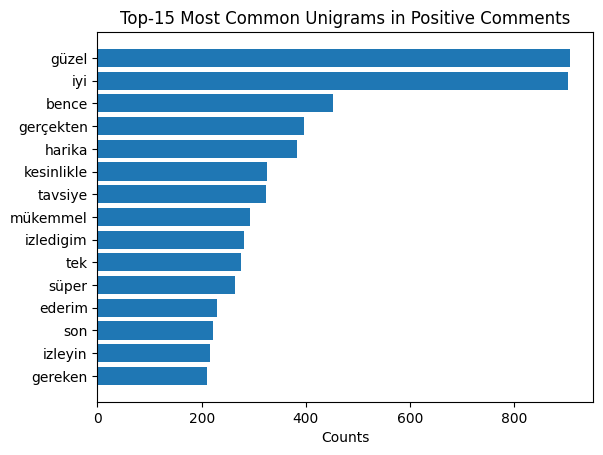

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Unigrams in Positive Comments')

plt.show()

### **NEGATİF SINIF UNIGRAMLARI**

In [ ]:
#negatif duygu için
df_neg=df_train[df_train["Label"]==0]

#sadece unigramlar
token_list=[]

for i,r in df_neg.iterrows():
    text=''.join(ch for ch in df_neg["comment"][i] if ch not in exclude and ch != "’")
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words]
    token_list.extend(tokens)

frequencies=Counter(token_list)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

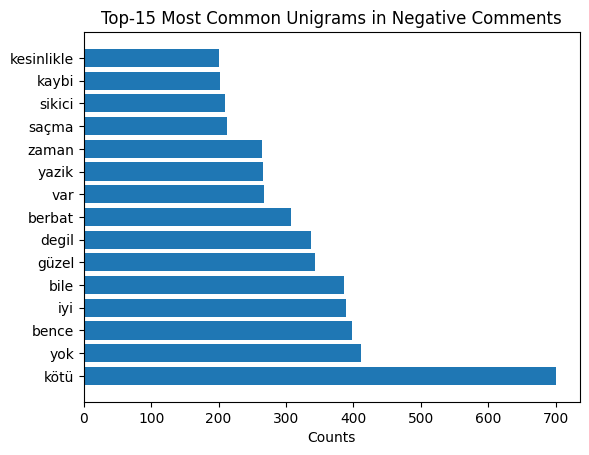

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Unigrams in Negative Comments')

plt.show()

### **POZİTİF SINIF UNIGRAMLARI**

In [ ]:
from nltk.util import ngrams

token_list=[]

for i,r in df_pos.iterrows():
    text=''.join(ch for ch in df_pos["comment"][i] if ch not in exclude and ch != "’")
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words]
    token_list.extend(tokens)


bigrams=list(ngrams(token_list,2))
frequencies=Counter(bigrams)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])


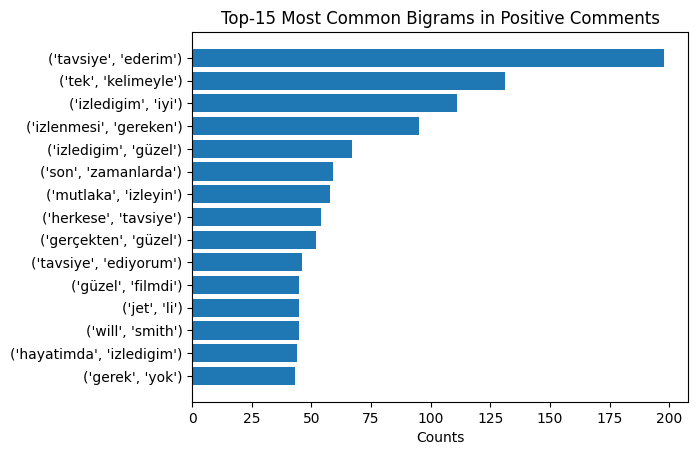

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()

ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Bigrams in Positive Comments')

plt.show()

In [ ]:
token_list=[]

for i,r in df_neg.iterrows():
    text=''.join(ch for ch in df_neg["comment"][i] if ch not in exclude and ch != "’")
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words]
    token_list.extend(tokens)


bigrams=list(ngrams(token_list,2))
frequencies=Counter(bigrams)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

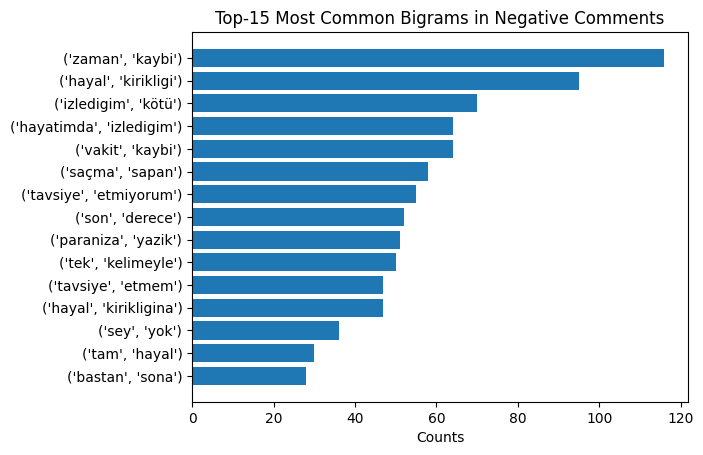

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()


ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Bigrams in Negative Comments')

plt.show()

# 2) BERTURK Model Fine Tuning

In [ ]:

comments = df_train.comment.values
labels = df_train.Label.values

https://stackoverflow.com/questions/54938815/data-preprocessing-for-nlp-pre-training-models-e-g-elmo-bert


In [ ]:
from transformers import AutoTokenizer
#Load BERT Turkish tokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased",do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

In [ ]:

import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

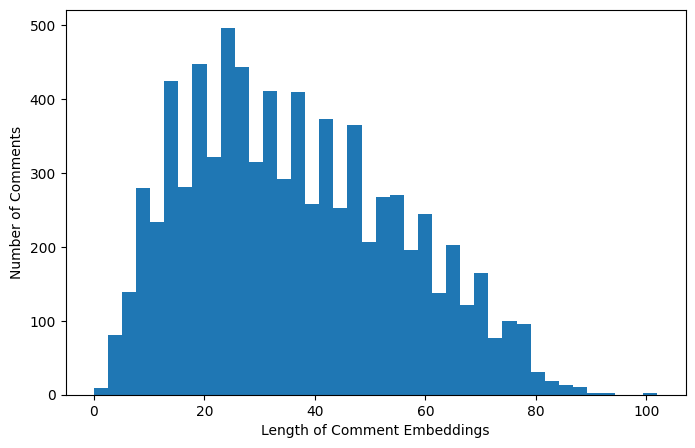

In [ ]:
plot_sentence_embeddings_length(comments,tokenizer)

In [ ]:

comments = list(comments)

indices = tokenizer.batch_encode_plus(
    comments,
    max_length=128,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True
)

input_ids = indices["input_ids"]
attention_masks = indices["attention_mask"]

print(input_ids[0])
print(comments[0])


[2, 2834, 2995, 2048, 11936, 2816, 6289, 26704, 7735, 2018, 16491, 4898, 8295, 1009, 12262, 1023, 3525, 18, 18, 2956, 2248, 2067, 4225, 12232, 6152, 3157, 12475, 11921, 2024, 5535, 6147, 1024, 16, 3176, 2473, 2577, 6147, 1024, 16, 5851, 2031, 6147, 1024, 11835, 2881, 2262, 27356, 4432, 6356, 2162, 2628, 22187, 1981, 13448, 10514, 3520, 4345, 83, 2045, 1008, 14668, 1028, 2960, 18, 14921, 7126, 30, 2048, 2142, 2010, 35, 22669, 18, 18, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
biri bana bu filmde benim anlamadigim bisey oldugunu söylesin lütfen.. uzun zamandir bilim kurgu vb tür filmleri izliyorum basit olanlari,mantiksiz olanlari,hatali olanlari gördüm ama böylesine rastlamadim saçma filmler kategorisinde kesin bi ödül alir film.kisaca:bu ne ya? diyorsunuz.. . 



In [ ]:
from sklearn.model_selection import train_test_split


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [ ]:

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig
config = AutoConfig.from_pretrained(
        "dbmdz/bert-base-turkish-cased",num_labels=2)

model = AutoModelForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-cased",config=config)

model.cuda()

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  betas=[0.9,0.999],
                  eps = 1e-6
                )
from transformers import get_linear_schedule_with_warmup

epochs = 20

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import numpy as np


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    # test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 30 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        loss = outputs[0]

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...
  Batch    30  of    200.    Elapsed: 0:00:18.
  Batch    60  of    200.    Elapsed: 0:00:35.
  Batch    90  of    200.    Elapsed: 0:00:52.
  Batch   120  of    200.    Elapsed: 0:01:10.
  Batch   150  of    200.    Elapsed: 0:01:27.
  Batch   180  of    200.    Elapsed: 0:01:45.

  Average training loss: 0.37
  Training epoch took: 0:01:57

Running Validation...
  Accuracy: 0.92
  Validation took: 0:00:10

======== Epoch 2 / 20 ========
Training...
  Batch    30  of    200.    Elapsed: 0:00:18.
  Batch    60  of    200.    Elapsed: 0:00:36.
  Batch    90  of    200.    Elapsed: 0:00:54.
  Batch   120  of    200.    Elapsed: 0:01:12.
  Batch   150  of    200.    Elapsed: 0:01:30.
  Batch   180  of    200.    Elapsed: 0:01:48.

  Average training loss: 0.18
  Training epoch took: 0:02:00

Running Validation...
  Accuracy: 0.93
  Validation took: 0:00:10

======== Epoch 3 / 20 ========
Training...
  Batch    30  of    200.    Elapsed: 0:00:18.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import os

# Modelin kaydedilmesi
output_dir = '/content/drive/MyDrive/model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Modeli kaydet
model_save_path = os.path.join(output_dir, 'bert_model_20.pth')
torch.save(model.state_dict(), model_save_path)

print(f"Model kaydedildi: {model_save_path}")


Model kaydedildi: /content/drive/MyDrive/model_save/bert_model_20.pth


# 3) BERTurk Model Performance on Test Set

In [ ]:
import torch

# Veriyi çektiğin dataframe'den 'comment' ve 'Label' sütunlarını al
comments1 = df_test['comment'].tolist()  # 'df_test' verisinde bulunan yorumlar
labels1 = df_test['Label'].tolist()      # 'df_test' verisinde bulunan etiketler

# Tokenizer işlemleri
indices1 = tokenizer.batch_encode_plus(
    comments1,
    max_length=128,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    truncation=True
)

input_ids1 = indices1["input_ids"]
attention_masks1 = indices1["attention_mask"]

# Convert data to tensors
prediction_inputs1 = torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)
prediction_labels1 = torch.tensor(labels1)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1, prediction_labels1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

print(input_ids1[0])
print(comments1[0])


[2, 28484, 2960, 6085, 6568, 16257, 2522, 3661, 2839, 14085, 2127, 2395, 2960, 10773, 3926, 6198, 5668, 5002, 18, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
arkadaslar film bence cok güzel su anda gidilebilecek en iyi film izlemenizi tavsiye ederim.. 



In [ ]:

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader1:

  batch = tuple(t.to(device) for t in batch)

  b_input_ids1, b_input_mask1, b_labels1 = batch

  with torch.no_grad():
      outputs1 = model(b_input_ids1, token_type_ids=None,
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  logits1 = logits1.detach().cpu().numpy()
  label_ids1 = b_labels1.to('cpu').numpy()

  predictions.append(logits1)
  true_labels.append(label_ids1)

print('    DONE.')

Predicting labels for 2,666 test sentences...
    DONE.


In [ ]:

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = [item for sublist in true_labels for item in sublist]

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print("Accuracy of BERT is:",accuracy_score(flat_true_labels, flat_predictions))
print(classification_report(flat_true_labels, flat_predictions))

Accuracy of BERT is: 0.931357839459865
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1333
           1       0.92      0.94      0.93      1333

    accuracy                           0.93      2666
   macro avg       0.93      0.93      0.93      2666
weighted avg       0.93      0.93      0.93      2666



In [ ]:

sentence = "faturaları zamanında ödememe rağmen hattım kapatılmış ve mağdur oluyorum"

inputs = tokenizer.encode_plus(
    sentence,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

# Model prediction
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

logits = outputs[0]

probabilities = torch.softmax(logits, dim=1)

predicted_label = torch.argmax(probabilities, dim=1).item()

print(f"Predicted Label: {predicted_label}")

label_mapping = {0: "Negatif", 1: "Pozitif"}
print(f"Sentiment: {label_mapping.get(predicted_label, 'Nötr')}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Predicted Label: 0
Sentiment: Negatif


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:

output_dir = '/content/drive/MyDrive/model_save2/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Modeli kaydet
print("Saving model to %s" % output_dir)

# Modelleri ve konfigürasyon dosyalarını kaydet
model_to_save = model.module if hasattr(model, 'module') else model  # Distributed/Parallel training

# Modelin ağırlıklarını kaydetmeden önce tüm tensorlerin contiguous olduğundan emin olun
for param in model_to_save.parameters():
    if not param.is_contiguous():
        param.data = param.contiguous()

# Modelin ağırlıklarını kaydet
model_to_save.save_pretrained(output_dir)

# Tokenizer'ı kaydet
tokenizer.save_pretrained(output_dir)

# Konfigürasyon dosyasını kaydet
model_to_save.config.save_pretrained(output_dir)

print("Model saved successfully!")

Saving model to /content/drive/MyDrive/model_save2/
Model saved successfully!


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Model ve tokenizer'ı yükleme
model_path = '/content/drive/MyDrive/model_save/bert_model_20.pth'  # Burada modelin .pth dosyasının yolunu belirleyin
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
model = BertForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-cased", num_labels=2)

# Modeli .pth dosyasından yükleme
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Tahmin edilen sınıfı döndürme
    if predicted_class == 0:
        return "Negative"
    else:
        return "Positive"

# Test metni
input_text = "operatör yüzünden faturam her ay olması gerekenden daha fazla "
prediction = predict_sentiment(input_text)
print(f"The sentiment of the input text is: {prediction}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The sentiment of the input text is: Negative
